# MNIST master

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

Before doing this homework, read some code examples written in tensorflow. There is a good repository with code examples: https://github.com/aymericdamien/TensorFlow-Examples. As we already know, we need many samples to learn :)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()
X_train = X_train.reshape(-1, 28,28,1) #/ 255
X_val = X_val.reshape(-1, 28,28,1) #/ 255
X_test = X_test.reshape(-1, 28,28,1) #/ 255

print(X_train.shape,y_train.shape)

(50000, 28, 28, 1) (50000,)


In [4]:
X_train.shape

(50000, 28, 28, 1)

4

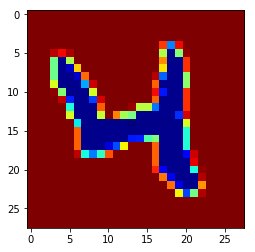

In [5]:
plt.imshow(-X_train[20, :, :, 0], cmap="jet")
y_train[20]

In [6]:
#defining placeholders for input and target
input_X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], 
                         name="X")
target_y = tf.placeholder(tf.int32, shape=[None], 
                          name="target_Y_integer")

Defining network architecture

In [7]:
# flatten images to (batch_size x 728) matrix
input_X_reshaped = tf.reshape(input_X, shape=[-1, 1*28*28], 
                              name="reshape_X")

# Fully connected layer, that takes input layer and applies 50 neurons 
# to it. Nonlinearity here is sigmoid as in logistic regression.
# You can give a name to each layer (optional)
l_out = input_X
l_out = tf.layers.conv2d(l_out, filters=32, kernel_size=5, activation=tf.nn.relu)
l_out = tf.layers.max_pooling2d(l_out, pool_size=2, strides=2)
l_out = tf.layers.conv2d(l_out, filters=64, kernel_size=3, activation=tf.nn.relu)
l_out = tf.layers.max_pooling2d(l_out, pool_size=2, strides=2)
l_out = tf.layers.flatten(l_out)
l_out = tf.layers.dense(l_out, units=1024)
l_out = tf.layers.dropout(l_out, 0.25)
l_out = tf.layers.dense(l_out, units=10, activation=None)

# We use softmax nonlinearity to make probabilities add up to 1
l_out = tf.nn.softmax(l_out)

# Prediction
y_predicted = tf.argmax(l_out, axis=-1)

In [8]:
weights = tf.trainable_variables()
weights

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(1600, 1024) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>]

### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Tensorflow builtins

In [9]:
# Mean categorical crossentropy as a loss function
# - similar to logistic loss but for multiclass targets
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=target_y, logits=l_out, name="softmax_loss"))

In [10]:
accuracy, update_accuracy = tf.metrics.accuracy(target_y, y_predicted)
tf.local_variables()

[<tf.Variable 'accuracy/total:0' shape=() dtype=float32_ref>,
 <tf.Variable 'accuracy/count:0' shape=() dtype=float32_ref>]

In [11]:
optimzer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimzer.minimize(loss)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [12]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

Model saver.
<br>
See more:
http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

In [13]:
model_path = "./checkpoints/model.ckpt"
saver = tf.train.Saver(max_to_keep=3)

In [14]:
import time

num_epochs = 30 # amount of passes through the data

batch_size = 200 # number of samples processed at each function call

with tf.Session() as sess:
    # initialize global wariables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()

        sess.run(tf.local_variables_initializer())
        for batch in iterate_minibatches(X_train, y_train,batch_size):
            inputs, targets = batch

            _, train_err_batch, _ = sess.run(
                [train_step, loss, update_accuracy], 
                feed_dict={input_X: inputs, target_y:targets}
            )
            train_err += train_err_batch
            train_batches += 1
        train_acc = sess.run(accuracy)

        # And a full pass over the validation data:
        sess.run(tf.local_variables_initializer())
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            sess.run(update_accuracy, feed_dict={input_X: inputs, 
                                                 target_y:targets})
        val_acc = sess.run(accuracy)


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc * 100))
        
        # save model
        save_path = saver.save(sess, model_path, global_step=epoch)
        print("  Model saved in file: %s" % save_path)

Epoch 1 of 30 took 47.666s
  training loss (in-iteration):		1.589371
  train accuracy:		87.70 %
  validation accuracy:		97.62 %
  Model saved in file: ./checkpoints/model.ckpt-0
Epoch 2 of 30 took 47.352s
  training loss (in-iteration):		1.484756
  train accuracy:		97.81 %
  validation accuracy:		98.30 %
  Model saved in file: ./checkpoints/model.ckpt-1
Epoch 3 of 30 took 47.011s
  training loss (in-iteration):		1.479105
  train accuracy:		98.28 %
  validation accuracy:		98.25 %
  Model saved in file: ./checkpoints/model.ckpt-2
Epoch 4 of 30 took 47.998s
  training loss (in-iteration):		1.477078
  train accuracy:		98.46 %
  validation accuracy:		98.34 %
  Model saved in file: ./checkpoints/model.ckpt-3
Epoch 5 of 30 took 49.023s
  training loss (in-iteration):		1.475187
  train accuracy:		98.64 %
  validation accuracy:		98.70 %
  Model saved in file: ./checkpoints/model.ckpt-4
Epoch 6 of 30 took 50.881s
  training loss (in-iteration):		1.474123
  train accuracy:		98.72 %
  validation a

Now we can restore saved parameters:

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    load_path = saver.restore(sess, saver.last_checkpoints[-1])
    print("Model restored from file: %s" % save_path)
    
    sess.run(tf.local_variables_initializer())
    for batch in iterate_minibatches(X_test, y_test, 500):
        inputs, targets = batch
        sess.run(update_accuracy, feed_dict={input_X: inputs, 
                                                   target_y:targets})
    test_acc = sess.run(accuracy)
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc* 100))

    if test_acc * 100 > 99.5:
        print ("Achievement unlocked: 80lvl Warlock!")
    else:
        print ("We need more magic!")

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-29
Model restored from file: ./checkpoints/model.ckpt-29
Final results:
  test accuracy:		99.02 %
We need more magic!


# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!